background removal of original image to replace with another scenary image.
1. replace background with the custom image.
2. replace background with AI generated image based on prompt.



#Install Segment-Anything

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-x2gugkue
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-x2gugkue
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=817d24495e7ebf4f7efb59d2fc15de0537a98328fcdd160a1e301f3e1202fa82
  Stored in directory: /tmp/pip-ephem-wheel-cache-aobr42jq/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


#Install modelbit to deploy ML model to the cloud `Runtime restart required.`

In [ ]:
!pip install modelbit

#Downloading model checkpoint and Creating a `SAM` model.

In [1]:
from segment_anything import SamPredictor,sam_model_registry
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from google.colab.patches import cv2_imshow


model_path='./sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)

--2024-01-26 03:32:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.33.21, 65.8.33.108, 65.8.33.12, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.33.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  19.9MB/s    in 17s     

2024-01-26 03:32:30 (20.9 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



#Downloading a `test_img`

---downloading image from the url: https://images.ctfassets.net/j4x7ugudy4uu/4N0RDxHUz31uhaXYS24cth/eaf00f8620a1899713def55eb9f1245d/sc_carousel_0_2x.jpg
Image downloaded and saved as test_img.jpg


(-0.5, 667.5, 667.5, -0.5)

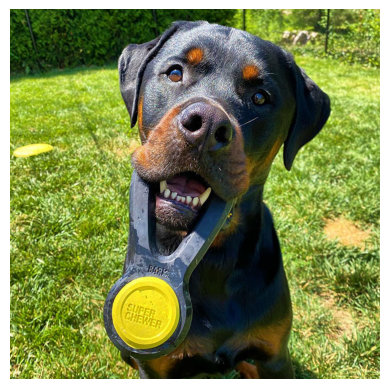

In [2]:
import requests

# URL of the image(sherlock)
# image_url = "https://i.pinimg.com/originals/f3/87/e1/f387e11f493953e9ed3b4be72c96cced.jpg"

# (dog)
image_url = "https://images.ctfassets.net/j4x7ugudy4uu/4N0RDxHUz31uhaXYS24cth/eaf00f8620a1899713def55eb9f1245d/sc_carousel_0_2x.jpg"

# man in a canoe
# image_url ="https://minneapolis2040.com/media/1115/goal11_cleanenvironment_womancanoeing.jpg"

# Specify the local filename
local_filename = "test_img.jpg"

if not os.path.exists(f'./{local_filename}'):

  print(f'---downloading image from the url: {image_url}')
  # Download the image
  response = requests.get(image_url)

  # Save the image with the specified filename
  with open(local_filename, 'wb') as file:
      file.write(response.content)

  print(f"Image downloaded and saved as {local_filename}")

img=cv.imread(f'./{local_filename}')
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img,cmap='gray')
plt.axis('off')

In [3]:
#use sam predictor on image to get the location of subject

x,y=300,300

predictor.set_image(img)
mask,_,_=predictor.predict(point_coords=np.asarray([[x,y]]),
                           point_labels=np.asarray([1]),
                           multimask_output=True)
print(mask.dtype)

bool


(3, 668, 668)


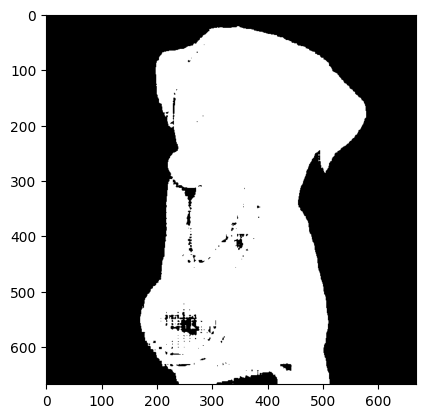

In [4]:
print(mask.shape)

C,H,W=mask.shape
result_mask=np.zeros((H,W),dtype=bool)
# plt.imshow(result_mask,cmap='gray')
for j in range(C):
  result_mask |= mask[j, :, :]

result_mask = result_mask.astype(np.uint8)

plt.imshow(result_mask,cmap="gray")

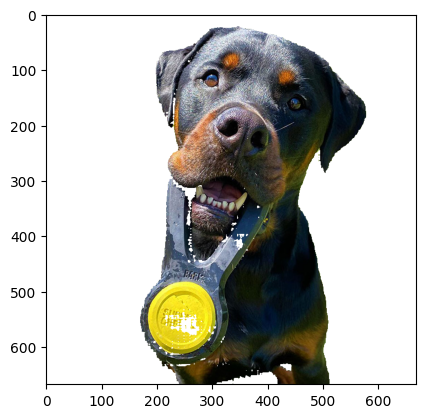

In [5]:
# remove background
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0
result_image = cv.merge((img, alpha_channel))

plt.imshow(result_image)

#FunctionTo_`remove_background`

In [6]:
import base64

def remove_background(image_base64_encoding,x,y):

  # decoding the b64 encoded image into numpy array format
  image_bytes = base64.b64decode(image_base64_encoding)
  image = cv.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv.IMREAD_COLOR)

  predictor.set_image(image)
  mask,_,_=predictor.predict(point_coords=np.asarray([[x,y]]),
                          point_labels=np.asarray([1]),
                          multimask_output=True)

  C,H,W=mask.shape
  result_mask=np.zeros((H,W),dtype=bool)

  for j in range(C):
    result_mask |= mask[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  # remove background
  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255
  alpha_channel[result_mask == 0] = 0
  result_image = cv.merge((image, alpha_channel))

  # encoding the image into b64 format
  _, result_image_bytes = cv.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64




In [7]:

# encoding image in base64 format
img=cv.imread('test_img.jpg')
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)

_, img_bytes = cv.imencode('.png',img)
img_bytes= img_bytes.tobytes()
image_bytes_encoded = base64.b64encode(img_bytes).decode('utf-8')

# sending the encoded image in `remove_background` function
final_image=remove_background(image_bytes_encoded,x,y)

# decoding the received encoded image from the function into simple numpy array
final_image_bytes = base64.b64decode(final_image)
final_image = cv.imdecode(np.frombuffer(final_image_bytes, dtype=np.uint8), cv.IMREAD_UNCHANGED)


<class 'numpy.ndarray'>


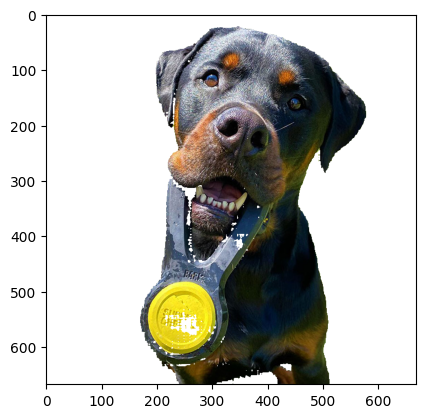

In [8]:
# final_image=cv.cvtColor(final_image, cv.COLOR_BGR2RGB)
print(type(final_image))
plt.imshow(final_image)
# plt.show()

#Modelbit- Making an API

In [9]:
# import modelbit
# mb = modelbit.login()

In [ ]:
# mb.deploy(remove_background)

#Calling from the API

In [11]:

api_endpoint ="https://rituramojha.ap-south-1.modelbit.com/v1/remove_background/latest"

# encoding image
img=cv.imread('test_img.jpg')
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)

_, img_bytes = cv.imencode('.png',img)
img_bytes= img_bytes.tobytes()
image_bytes_encoded = base64.b64encode(img_bytes).decode('utf-8')

# calling from the api
api_data = {"data": [image_bytes_encoded, x, y]}
response = requests.post(api_endpoint, json=api_data)

final_image = response.json()['data']

# decoding the received encoded image from the function into simple numpy array
final_image_bytes = base64.b64decode(final_image)
final_image_api = cv.imdecode(np.frombuffer(final_image_bytes, dtype=np.uint8), cv.IMREAD_UNCHANGED)


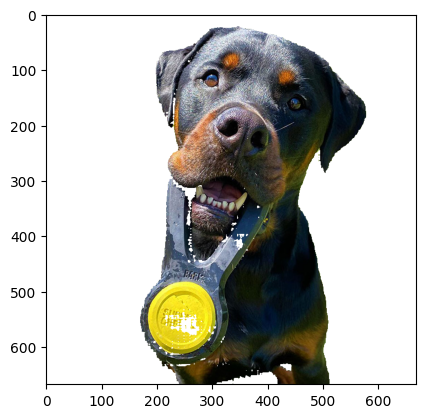

In [12]:
plt.imshow(final_image_api)